In [ ]:
import pandas as pd
import numpy as np

# Load the dataset
# The delimiter is ';' and the decimal separator is ','
df = pd.read_csv('AirQuality.csv', delimiter=';')

# Handle missing values: replace -200 with NaN
df.replace(-200, np.nan, inplace=True)

# Correct data types and convert decimal separators
# Convert relevant columns to float, replacing ',' with '.'
for col in ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)']:
    # Check if the column exists and is of object type (string) before applying .str.replace()
    if col in df.columns and df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False).astype(float)
    elif col in df.columns:
        # If the column is already numeric, ensure it's float and handle NaNs if any
        df[col] = pd.to_numeric(df[col], errors='coerce')


# Combine 'Date' and 'Time' into a single 'DateTime' column
# The format is '%d/%m/%Y %H.%M.%S' for 'Date' and 'Time' respectively
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')

# Drop the original 'Date' and 'Time' columns
df.drop(['Date', 'Time',',,,,,'], axis=1, inplace=True)

# Remove unnecessary columns (empty columns at the end)
# Identify columns that are all NaN after preprocessing
df.dropna(axis=1, how='all', inplace=True)

# Optional: Rename columns for better readability
# Example for a few columns, extend as needed
df.rename(columns={
    'CO(GT)': 'CO_GT',
    'PT08.S1(CO)': 'PT08_S1_CO',
    'NMHC(GT)': 'NMHC_GT',
    'C6H6(GT)': 'C6H6_GT',
    'PT08.S2(NMHC)': 'PT08_S2_NMHC',
    'NOx(GT)': 'NOx_GT',
    'PT08.S3(NOx)': 'PT08_S3_NOx',
    'NO2(GT)': 'NO2_GT',
    'PT08.S4(NO2)': 'PT08_S4_NO2',
    'PT08.S5(O3)': 'PT08_S5_O3',
    'T': 'Temperature',
    'RH': 'Relative_Humidity',
    'AH': 'Absolute_Humidity'
}, inplace=True)

# Display the first few rows of the cleaned dataframe and its info
print("Cleaned DataFrame Head:")
print(df.head())
print("\nCleaned DataFrame Info:")
print(df.info())
print("\n--- Descriptive Statistics for Numerical Columns ---")
print(df.describe())
print("\n--- Number of Unique Values per Column (excluding DateTime) ---")
for col in df.columns:
    if col != 'DateTime': # Exclude DateTime for unique counts as it's typically unique for each row
        print(f"{col}: {df[col].nunique()} unique values")

print("\n--- Correlation Matrix for Numerical Columns ---")
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
print(numerical_df.corr())

Cleaned DataFrame Head:
   CO_GT  PT08_S1_CO  NMHC_GT  C6H6_GT  PT08_S2_NMHC  NOx_GT  PT08_S3_NOx  \
0    2.6      1360.0    150.0     11.9        1046.0   166.0       1056.0   
1    2.0      1292.0    112.0      9.4         955.0   103.0       1174.0   
2    2.2      1402.0     88.0      9.0         939.0   131.0       1140.0   
3    2.2      1376.0     80.0      9.2         948.0   172.0       1092.0   
4    1.6      1272.0     51.0      6.5         836.0   131.0       1205.0   

   NO2_GT  PT08_S4_NO2  PT08_S5_O3  Temperature  Relative_Humidity  \
0   113.0       1692.0      1268.0         13.6               48.9   
1    92.0       1559.0       972.0         13.3               47.7   
2   114.0       1555.0      1074.0         11.9               54.0   
3   122.0       1584.0      1203.0         11.0               60.0   
4   116.0       1490.0      1110.0         11.2               59.6   

   Absolute_Humidity            DateTime  
0             0.7578 2004-03-10 18:00:00  
1     


--- Random Forest Classifier Evaluation ---
Accuracy: 0.8643

Classification Report:
              precision    recall  f1-score   support

         Low       0.88      0.86      0.87       709
      Medium       0.85      0.87      0.86       820
        High       0.86      0.87      0.86       343

    accuracy                           0.86      1872
   macro avg       0.86      0.86      0.86      1872
weighted avg       0.86      0.86      0.86      1872


--- Feature Importances ---
NOx_GT               0.163246
PT08_S2_NMHC         0.148814
C6H6_GT              0.144282
NO2_GT               0.127430
PT08_S1_CO           0.103852
PT08_S5_O3           0.088471
PT08_S3_NOx          0.056981
PT08_S4_NO2          0.045145
Temperature          0.040124
Absolute_Humidity    0.039288
Relative_Humidity    0.033451
NMHC_GT              0.008915
dtype: float64


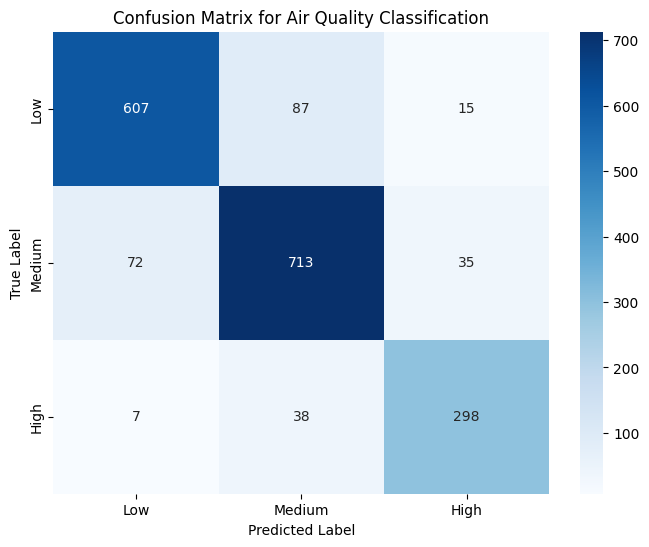

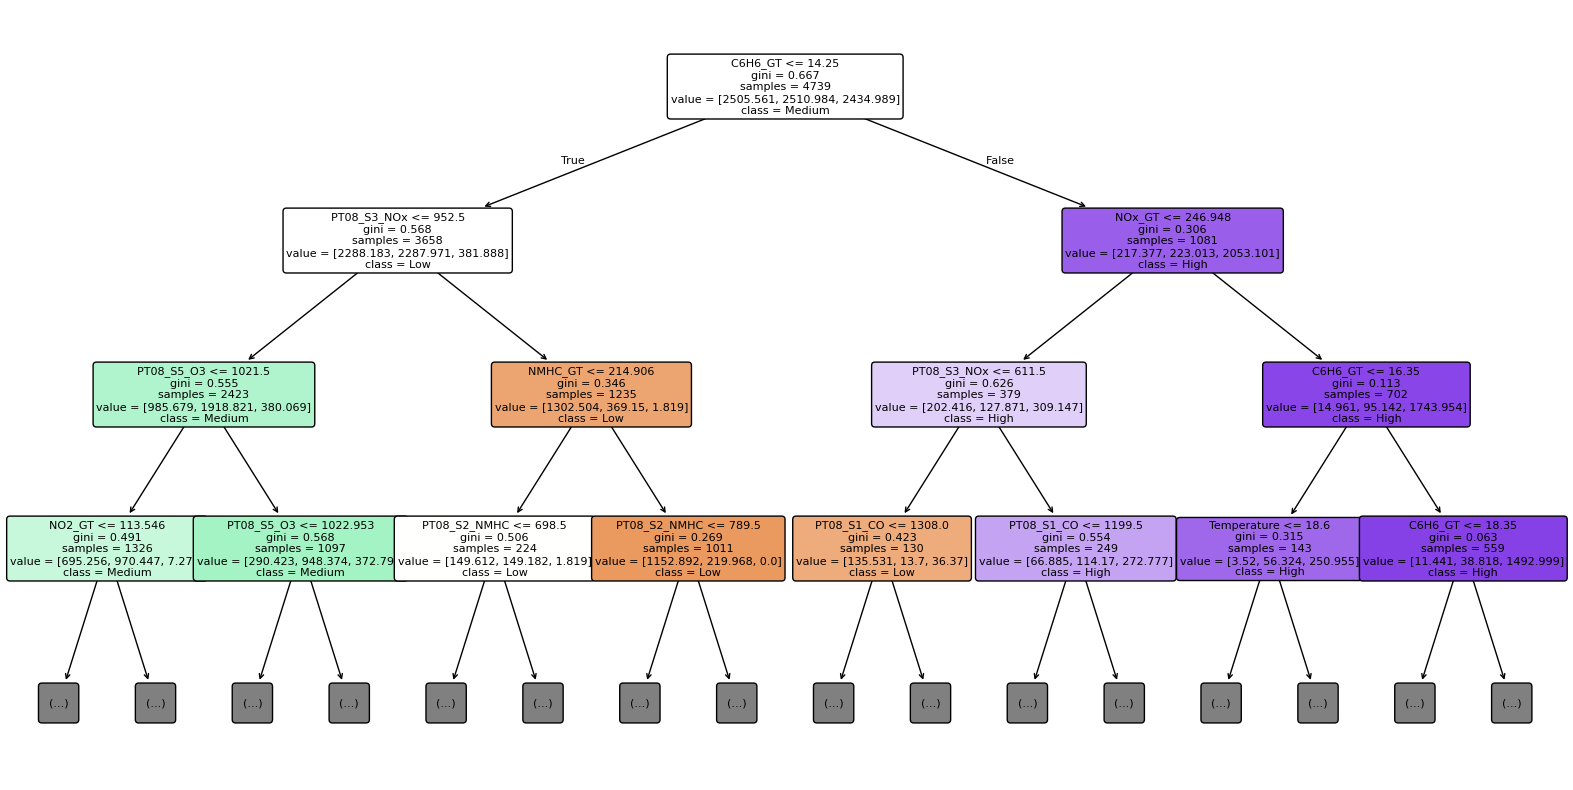

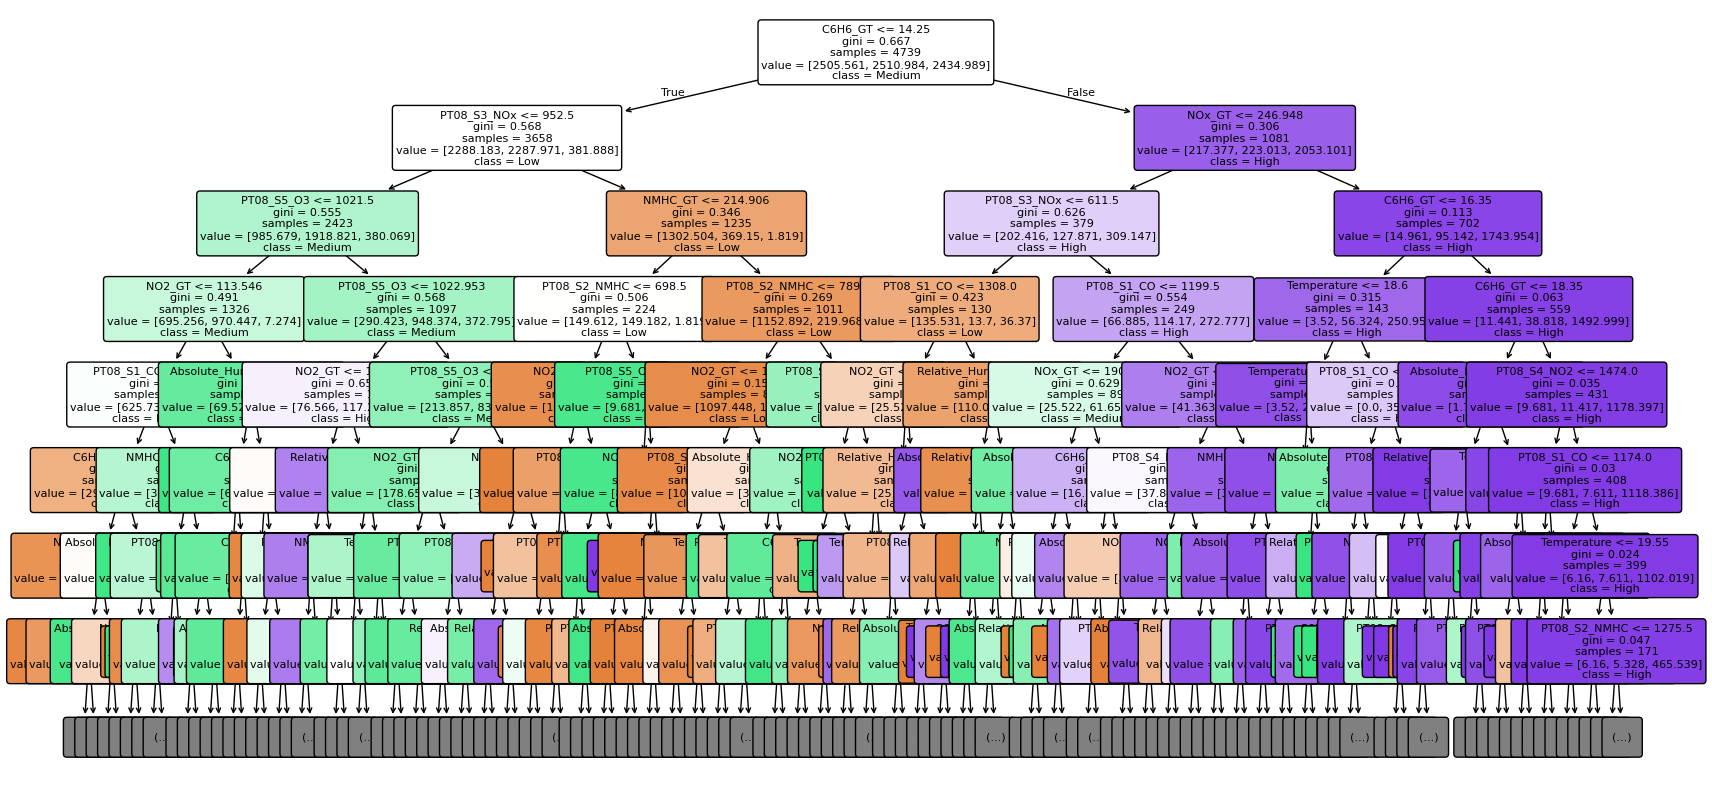

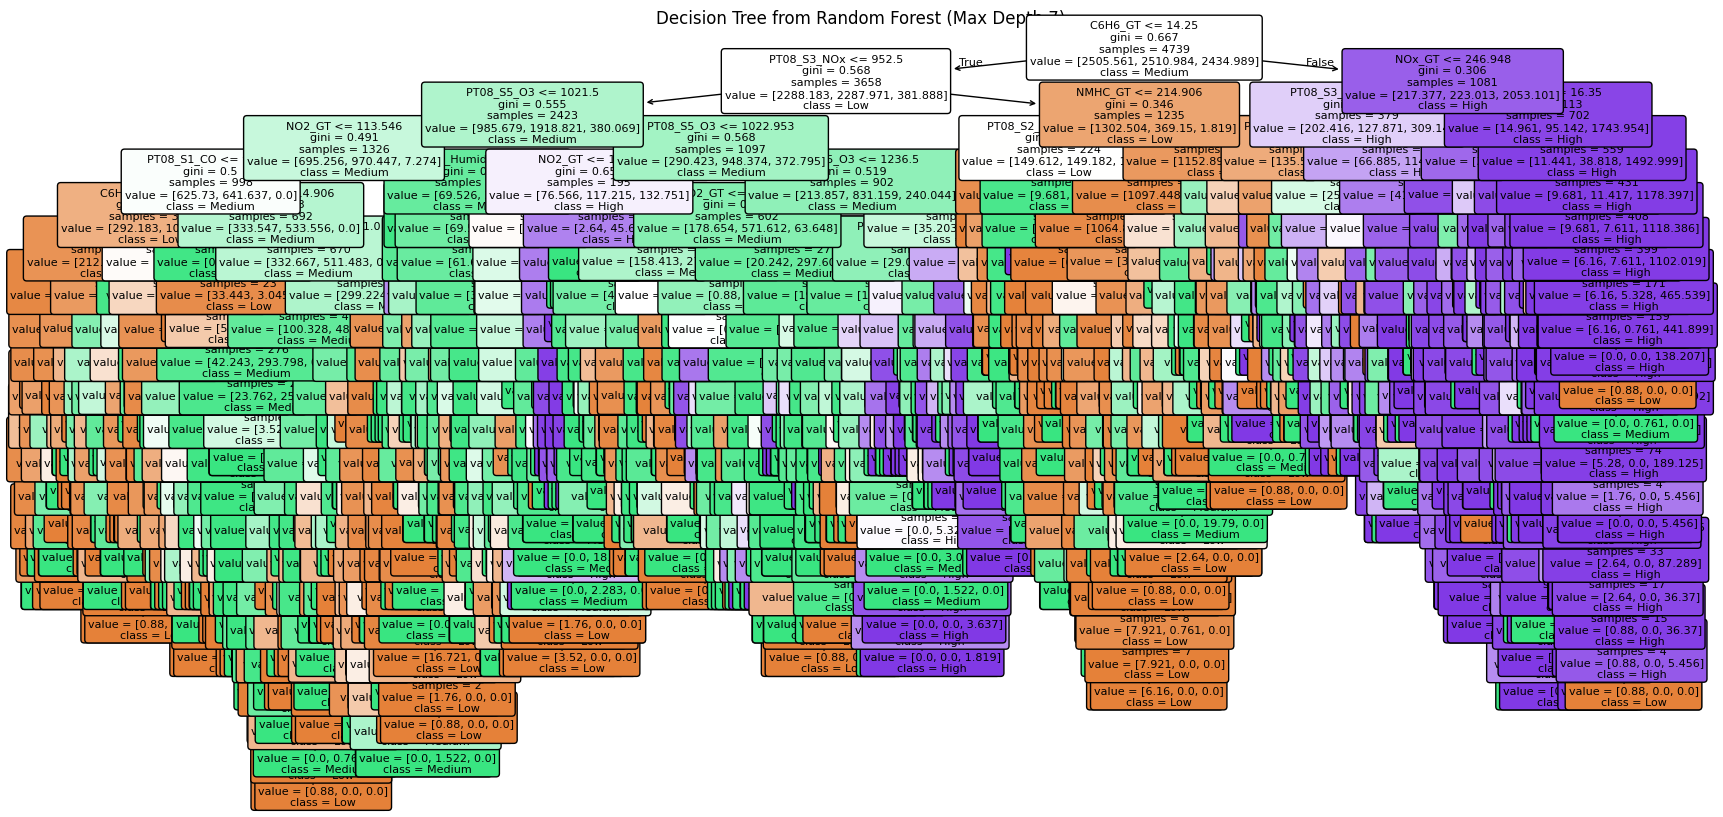

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree


def classify_co_level(co_value):
    if pd.isna(co_value):
        return np.nan # Keep NaN for now, will impute later
    elif co_value <= 1.0:
        return 'Low'
    elif co_value <= 3.0:
        return 'Medium'
    else:
        return 'High'

df['CO_Quality_Level'] = df['CO_GT'].apply(classify_co_level)

# Drop rows where the target variable 'CO_Quality_Level' is NaN
# This is crucial because our target variable cannot have missing values for classification
df.dropna(subset=['CO_Quality_Level'], inplace=True)

# Convert the categorical target to numerical labels
# This is often required by ML algorithms, or for consistent handling
df['CO_Quality_Level'] = df['CO_Quality_Level'].map({'Low': 0, 'Medium': 1, 'High': 2})


# --- Prepare Features (X) and Target (y) ---
# Drop the original 'CO_GT' (as we created a categorical version), 'CO_Quality_Level' itself,
# and 'DateTime' as it's not a direct feature for Random Forest Classifier.
# 'errors='ignore'' handles cases where a column might already be dropped or not exist.
X = df.drop(['CO_GT', 'CO_Quality_Level', 'DateTime'], axis=1, errors='ignore')
y = df['CO_Quality_Level']

# --- Handle Remaining Missing Values in Features (X) ---
# Select only numerical columns for imputation, ensuring no non-numeric columns remain.
X_numeric = X.select_dtypes(include=np.number)

# Impute missing values in numerical features using the mean strategy.
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X_numeric), columns=X_numeric.columns, index=X_numeric.index)


# --- Split the Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)
# stratify=y ensures that the proportion of classes in the target variable is the same in both
# the training and testing sets, which is good practice for classification tasks.

# --- Initialize and Train the Random Forest Classifier ---
# You can tune parameters like n_estimators (number of trees), max_depth, etc.
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
# class_weight='balanced' can help if your classes are imbalanced

rf_classifier.fit(X_train, y_train)

# --- Make Predictions ---
y_pred = rf_classifier.predict(X_test)

# --- Evaluate the Model ---
print("\n--- Random Forest Classifier Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
# Ensure target_names align with your class mapping (0: Low, 1: Medium, 2: High)
target_names = ['Low', 'Medium', 'High']
print(classification_report(y_test, y_pred, target_names=target_names))

print("\n--- Feature Importances ---")
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X_imputed.columns)
print(feature_importances.sort_values(ascending=False))

cm=confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Air Quality Classification')
plt.show()

plt.figure(figsize=(20, 10)) # Adjust figure size for better visibility
# Select the first tree from the forest for visualization
tree_to_visualize = rf_classifier.estimators_[0]
plot_tree(tree_to_visualize,
          feature_names=X_imputed.columns.tolist(),
          class_names=target_names,
          filled=True, # Color nodes to indicate majority class
          rounded=True, # Round node corners
          proportion=False, # Show samples not proportions
          fontsize=8,
          max_depth=3
         )
plt.figure(figsize=(20, 10))
tree_to_visualize = rf_classifier.estimators_[0]
plot_tree(tree_to_visualize,
          feature_names=X_imputed.columns.tolist(),
          class_names=target_names,
          filled=True,
          rounded=True,
          proportion=False,
          fontsize=8,
          max_depth=7
         )
plt.figure(figsize=(20, 10))
tree_to_visualize = rf_classifier.estimators_[0]
plot_tree(tree_to_visualize,
          feature_names=X_imputed.columns.tolist(),
          class_names=target_names,
          filled=True,
          rounded=True,
          proportion=False,
          fontsize=8
         )

plt.title('Decision Tree from Random Forest (Max Depth 7)')
plt.show()


--- Random Forest Regressor Evaluation ---
Root Mean Squared Error (RMSE): 34.6960
R-squared (R^2): 0.7962


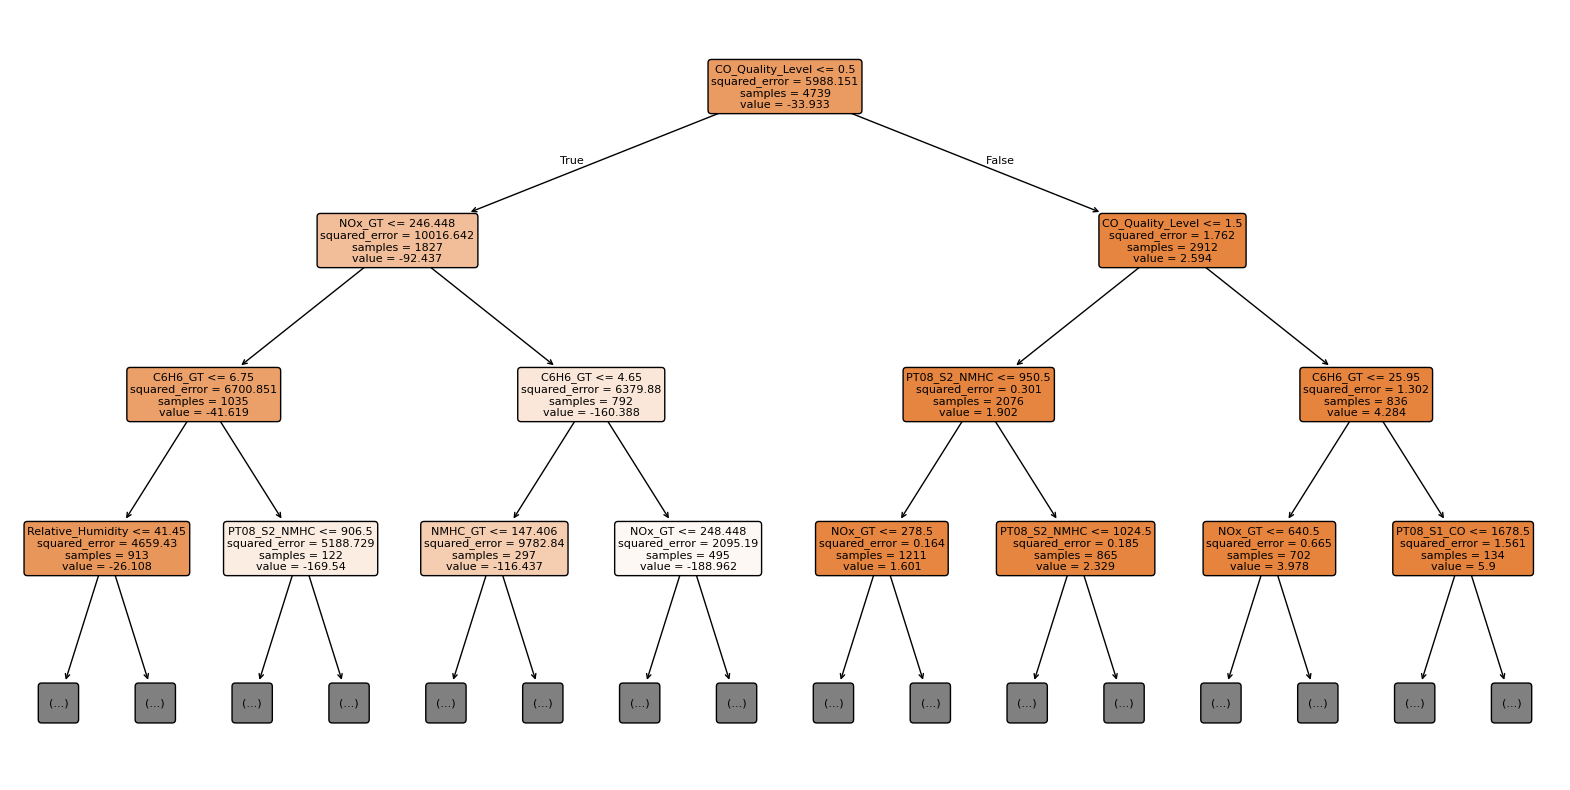

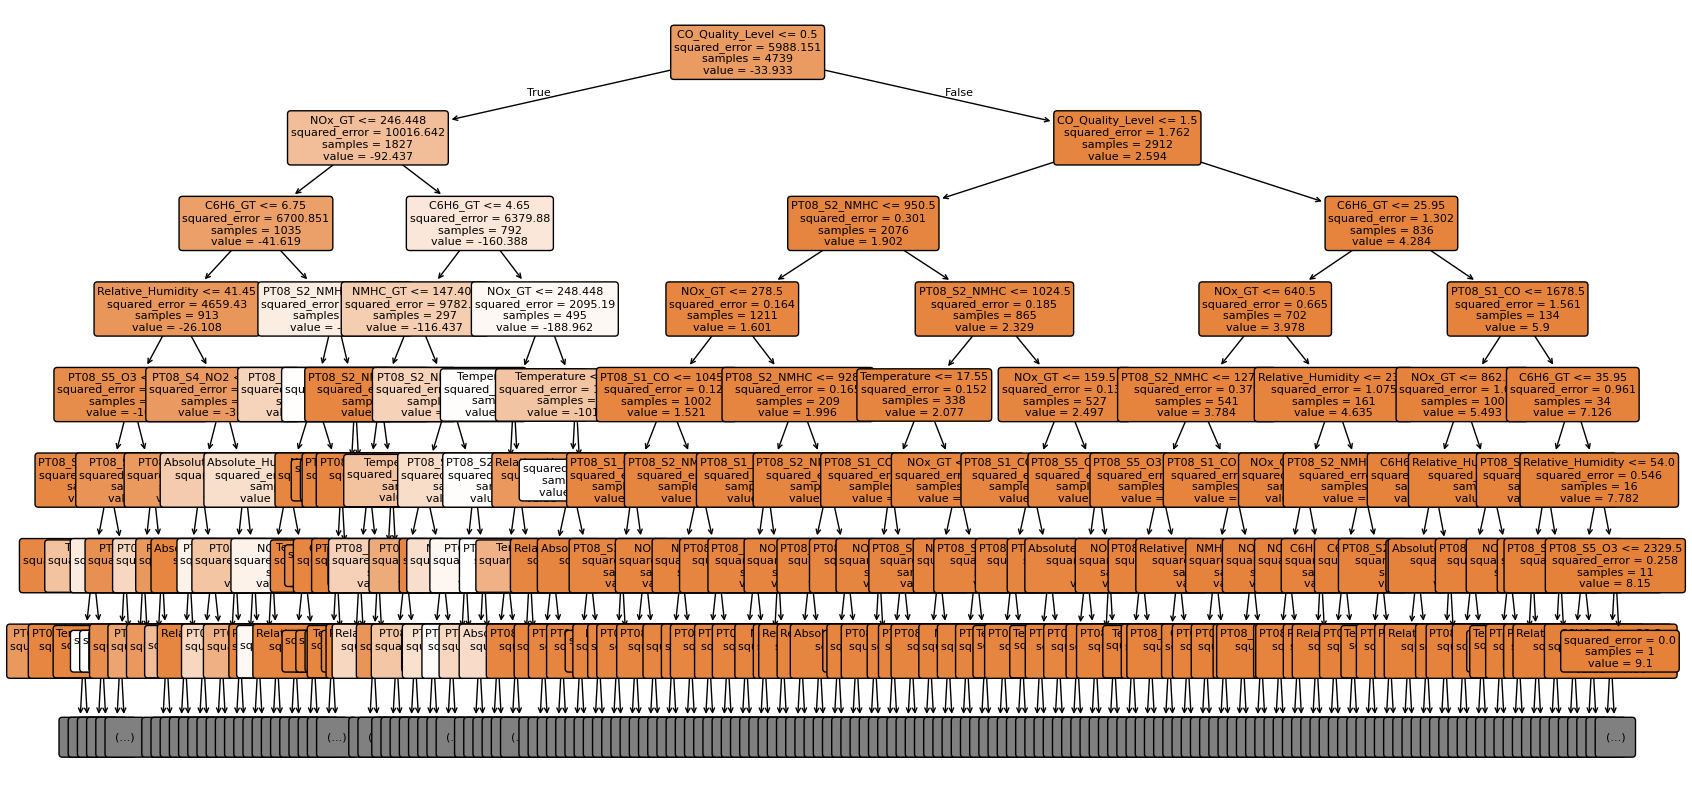

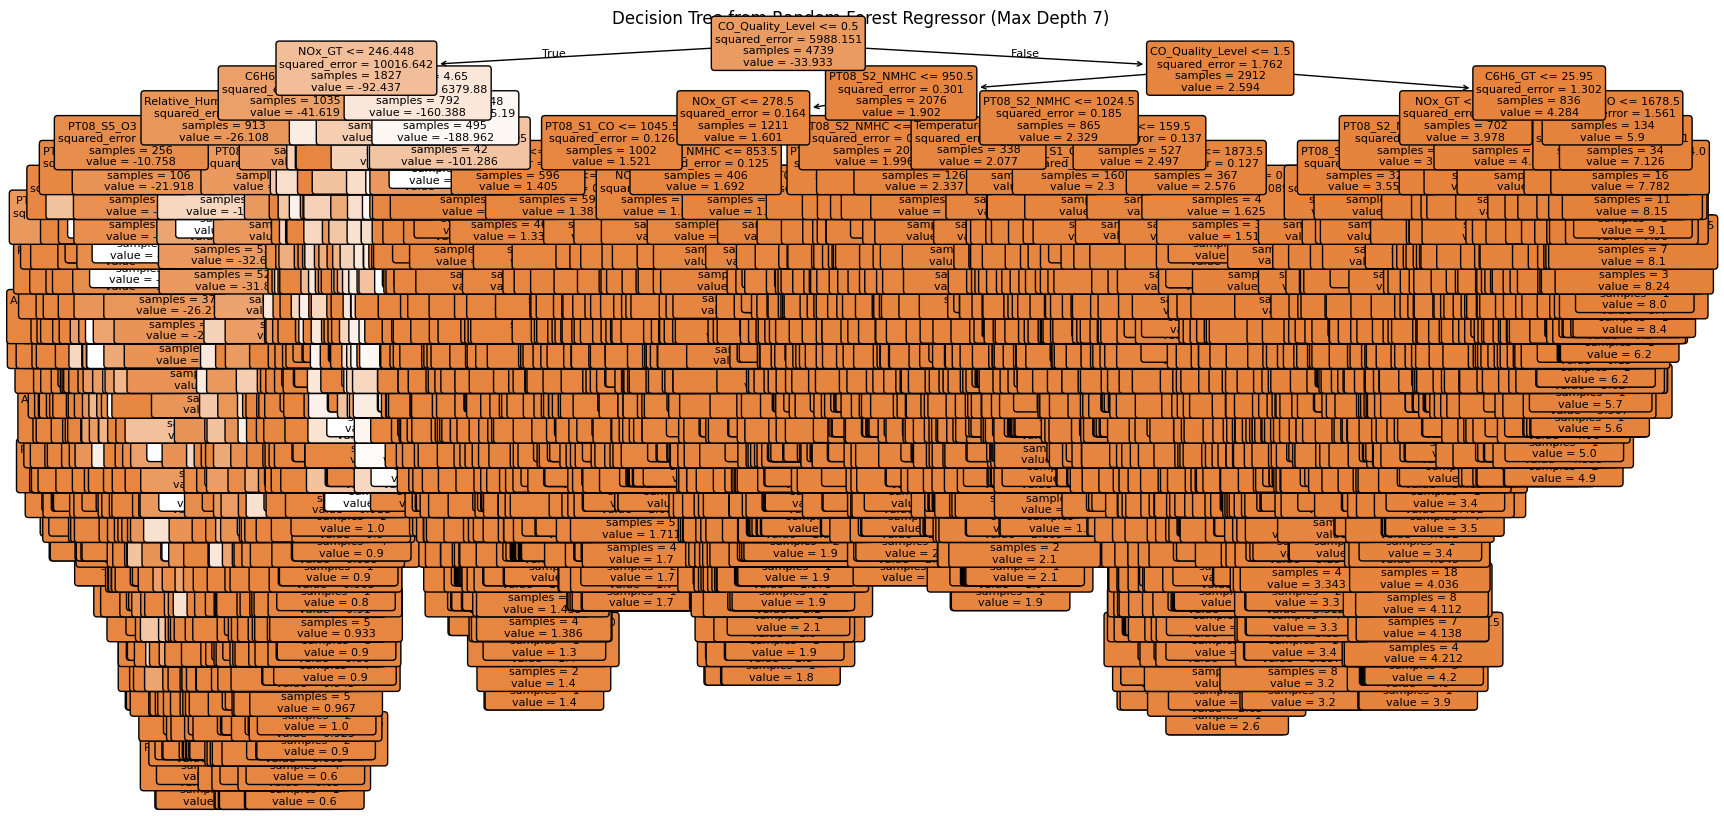


--- Feature Importances ---
CO_Quality_Level     0.370426
NOx_GT               0.159940
NO2_GT               0.109943
C6H6_GT              0.084691
PT08_S2_NMHC         0.045382
PT08_S4_NO2          0.038960
Temperature          0.032370
PT08_S1_CO           0.032348
PT08_S5_O3           0.031030
PT08_S3_NOx          0.029218
Relative_Humidity    0.028535
Absolute_Humidity    0.026249
NMHC_GT              0.010909
dtype: float64


In [35]:
df.dropna(subset=['CO_GT'], inplace=True)
y = df['CO_GT']

# --- Prepare Features (X) ---
# Select only numerical columns for features, and drop the target 'CO_GT' and 'DateTime'.
X = df.select_dtypes(include=np.number).drop(['CO_GT'], axis=1, errors='ignore')

# --- Handle Remaining Missing Values in Features (X) ---
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)


# --- Split the Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# --- Initialize and Train the Random Forest Regressor ---
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 to use all cores
rf_regressor.fit(X_train, y_train)

# --- Make Predictions ---
y_pred = rf_regressor.predict(X_test)

# --- Evaluate the Model (Regression Metrics) ---
print("\n--- Random Forest Regressor Evaluation ---")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE) (max_depth = 7):  {rmse:.4f}")
print(f"R-squared (R^2) (max_depth = 7): {r2:.4f}")

# --- Visualize a Single Tree from the Random Forest Regressor ---
plt.figure(figsize=(20, 10)) # Adjust figure size for better visibility
# Select the first tree from the forest for visualization
tree_to_visualize = rf_regressor.estimators_[0]
plot_tree(tree_to_visualize,
          feature_names=X_imputed.columns.tolist(),
          filled=True, # Color nodes to indicate majority class
          rounded=True, # Round node corners
          fontsize=8, # Limit depth for readability, remove for full tree
          max_depth=3
         )

plt.figure(figsize=(20, 10))
tree_to_visualize = rf_regressor.estimators_[0]
plot_tree(tree_to_visualize,
          feature_names=X_imputed.columns.tolist(),
          filled=True,
          rounded=True,
          fontsize=8,
          max_depth=7
         )

plt.figure(figsize=(20, 10))
tree_to_visualize = rf_regressor.estimators_[0]
plot_tree(tree_to_visualize,
          feature_names=X_imputed.columns.tolist(),
          filled=True,
          rounded=True,
          fontsize=8
         )
plt.title('Decision Tree from Random Forest Regressor (Max Depth 7)')
plt.show()

print("\n--- Feature Importances ---")
feature_importances = pd.Series(rf_regressor.feature_importances_, index=X_imputed.columns)
print(feature_importances.sort_values(ascending=False))